# Informasi Dataset

## Import Libraries

In [54]:
# Exploratory Data Analysis
import pandas as pd
import numpy as np

# Scikit Learn Machine Learning
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Save model
import joblib

## Membaca Data Training

In [55]:
# Import Dataset
df = pd.read_excel('traintest.xlsx', sheet_name="train")
df.sample(5)

,id,x1,x2,x3,y
133,134,58,61,1,1
265,266,52,60,4,1
167,168,69,66,0,1
90,91,61,59,0,1
261,262,30,64,1,1


In [56]:
# General Info Dataset
df.describe()

,id,x1,x2,x3,y
count,296.000000,296.000000,296.000000,296.000000,296.000000
mean,148.500000,52.462838,62.881757,4.111486,0.736486
std,85.592056,10.896367,3.233753,7.291816,0.441285
min,1.000000,30.000000,58.000000,0.000000,0.000000
25%,74.750000,44.000000,60.000000,0.000000,0.000000
50%,148.500000,52.000000,63.000000,1.000000,1.000000
75%,222.250000,61.000000,65.250000,5.000000,1.000000
max,296.000000,83.000000,69.000000,52.000000,1.000000


In [57]:
df.shape

(296, 5)

## Exploratory Data Analysis

In [58]:
df.isna().sum()

id    0
x1    0
x2    0
x3    0
y     0
dtype: int64

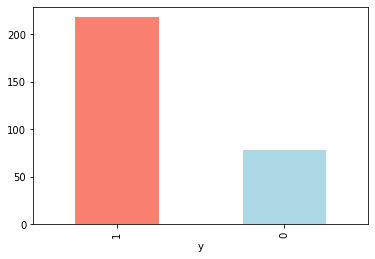

In [59]:
df["y"].value_counts().plot(kind="bar", color=["salmon", "lightblue"]);

<AxesSubplot:>

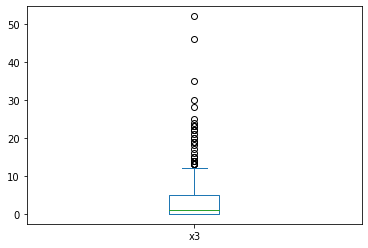

In [60]:
df.x3.plot(kind='box')

In [61]:
df[df.x3>26]

,id,x1,x2,x3,y
77,78,43,58,52,0
129,130,59,62,35,0
169,170,34,58,30,1
200,201,63,61,28,1
201,202,54,67,46,1


In [62]:
df.drop([77,201,129],inplace=True)

<AxesSubplot:>

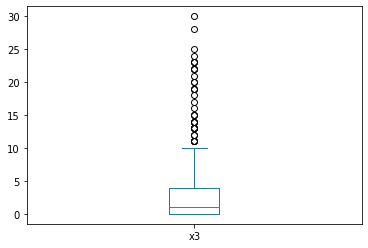

In [63]:
df.x3.plot(kind='box')

In [64]:
len(df.index)

293

# Modelling

## Inisiasi Variabel

In [65]:
model = KNeighborsClassifier(metric='euclidean')
X = df.drop(['y', 'id'], axis=1)
y = df.y

## Normalisasi Data

In [66]:
class Normalize:
    def __init__(self):
        self.means_ = None
        self.stds_ = None

    def fit(self, X):
        # Hitung rata-rata tiap fitur
        self.means_ = X.mean()
        self.stds_ = X.std()

    def transform(self, X):
        return (X - self.means_) / self.stds_

    def fit_transform(self, X):
        self.fit(X)
        return self.transform(X)

In [67]:
def preprocess_data(X_train, X_test):
    scaler = Normalize()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    return X_train_scaled, X_test_scaled, scaler


## Training Model

In [68]:
def train_model(X_train_scaled, y_train, n_neighbors=5):
    model.set_params(n_neighbors=n_neighbors, metric="euclidean")
    model.fit(X_train_scaled, y_train)
    return model

def skor_akurasi(model, X_test_scaled, y_test):
    y_pred = model.predict(X_test_scaled)
    
    correct_predictions = np.sum(y_pred == y_test)
    total_samples = len(y_test)
    accuracy = correct_predictions / total_samples

    return accuracy


## Cross Validation

In [69]:
def cross_validation(X, y, n_neighbors=5, n_splits=10):
    model.set_params(n_neighbors=n_neighbors)
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=47)

    accuracies = []
    for train_index, test_index in kf.split(X):
        # Handle warning, ignore this. cek apakah X = DataFrame ato numpy
        if isinstance(X, pd.DataFrame):
            X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        else:
            X_train, X_test = X[train_index], X[test_index]

        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        X_train_scaled, X_test_scaled, _ = preprocess_data(X_train, X_test)
        model.fit(X_train_scaled, y_train)

        accuracies.append(skor_akurasi(model, X_test_scaled, y_test))

    return np.mean(accuracies)


# Hyperparameter Tuning

In [70]:
iterasi = range (1,11)
def model_tuning(scoring_method):
    train_scores = []
    test_scores = []
    
    for i in iterasi:
        model.set_params(n_neighbors=i, metric='euclidean')
        model.fit(X_train_scaled, y_train)

        if scoring_method == "knn":
            train_scores.append(model.score(X_train_scaled, y_train))
            test_scores.append(model.score(X_test_scaled, y_test))
            # print(f"K = {i},\t Skor: {model.score(X_test_scaled, y_test)*100:.2f}%")
        elif scoring_method == "cv":
            train_scores.append(cross_validation(X_train_scaled, y_train, i))
            test_scores.append(cross_validation(X_test_scaled, y_test, i))
            #print(f"K = {i},\t Skor: {cross_validation(X_train_scaled, y_train, i)*100:.2f}%")
    
    return train_scores, test_scores


# Evaluasi Model

In [71]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=60, random_state=47)
X_train_scaled, X_test_scaled, scaler = preprocess_data(X_train, X_test)

# Train model
model = train_model(X_train_scaled, y_train)

train_score_accuracy, test_score_accuracy = model_tuning("knn")
train_score_cv, test_score_cv = model_tuning("cv")

## Perbandingan Skor Akurasi Training vs Testing Set

In [72]:
compare1 = {"K-Neighbors:": [x for x in iterasi], "Training": [y for y in train_score_accuracy],"Testing": [z for z in test_score_accuracy]}
compare1_display = pd.DataFrame(compare1)
compare1_display

,K-Neighbors:,Training,Testing
0,1,0.978541,0.683333
1,2,0.841202,0.616667
2,3,0.828326,0.716667
3,4,0.781116,0.683333
4,5,0.776824,0.733333
5,6,0.763948,0.750000
6,7,0.746781,0.750000
7,8,0.738197,0.733333
8,9,0.759657,0.816667
9,10,0.746781,0.766667


## Perbandingan Skor Testing Akurasi dan Cross Validation

In [73]:
compare2 = {'K-Neighbors':[x for x in iterasi], 'Accuracy Score': test_score_accuracy, 'Cross Validation Score': test_score_cv}
wizz = pd.DataFrame(compare2)

# Highlight row dengan skor akurasi yang paling tinggi
maks = (wizz['Accuracy Score'] == wizz['Accuracy Score'].max())

# Apply style ke DataFrame
compare2_display = wizz.style.apply(lambda x: ['background-color: black; font-weight: bold; color: #8BE9FD' if v else '' for v in x], subset=pd.IndexSlice[maks, :])
compare2_display


,K-Neighbors,Accuracy Score,Cross Validation Score
0,1,0.683333,0.766667
1,2,0.616667,0.716667
2,3,0.716667,0.783333
3,4,0.683333,0.766667
4,5,0.733333,0.766667
5,6,0.750000,0.766667
6,7,0.750000,0.783333
7,8,0.733333,0.766667
8,9,0.816667,0.800000
9,10,0.766667,0.783333


## Summary Report

In [74]:
get_highest_result = wizz[wizz["Accuracy Score"] == wizz["Accuracy Score"].max()].iloc[0]["K-Neighbors"]
highest_result = get_highest_result.astype(int)

Accuracy: 0.8166666666666667
Cross Validation:  0.8


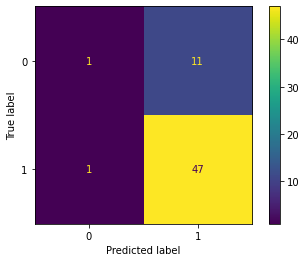

In [75]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=60, random_state=47)
X_train_scaled, X_test_scaled, scaler = preprocess_data(X_train, X_test)

# Train model
model = train_model(X_train_scaled, y_train, highest_result)

# Evaluate model
accuracy = skor_akurasi(model, X_test_scaled, y_test)
print("Accuracy:", accuracy)
print("Cross Validation: ", cross_validation(X_test_scaled, y_test, highest_result))

# Display confusion matrix
cm = confusion_matrix(y_test, model.predict(X_test_scaled), labels=[0, 1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot();


# Pengujian Model pada Dataset Testing

## Menyimpan Model

In [76]:
def saveNload_model(model, file_path='Results/KNN.joblib'):
    # Save model dgn akurasi terbaik
    idx = model_tuning("knn")[1].index(max(model_tuning("knn")[1])) + 1
    knn_optimized = model.set_params(n_neighbors=idx)
    joblib.dump(knn_optimized, file_path)
    return joblib.load(file_path)

In [77]:
model = saveNload_model(model)

## Menguji Model

In [78]:
def test_model(model, test_data):
    X_test_data = test_data[['x1', 'x2', 'x3']]

    predictions = model.predict(X_test_data)
    return predictions

In [79]:
test_data = pd.read_excel('traintest.xlsx', sheet_name='test')
final_result = test_model(model, test_data)

## Menyimpan Hasil Prediksi ke Excel

In [80]:
save_this = pd.DataFrame({
                "id": [id for id in test_data.id],
                "x1": [x1 for x1 in test_data.x1],
                "x2": [x2 for x2 in test_data.x2],
                "x3": [x3 for x3 in test_data.x3],
                "y": final_result
            })

save_this

,id,x1,x2,x3,y
0,297,43,59,2,1
1,298,67,66,0,1
2,299,58,60,3,1
3,300,49,63,3,1
4,301,45,60,0,1
5,302,54,58,1,1
6,303,56,66,3,1
7,304,42,69,1,1
8,305,50,59,2,1
9,306,59,60,0,1


In [81]:
save_this.to_excel('Results/result.xlsx', index=False)